In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("..")

In [3]:
from deepsvg.svglib.svg import SVG

from deepsvg import utils
from deepsvg.difflib.tensor import SVGTensor
from deepsvg.svglib.utils import to_gif, make_grid, make_grid_lines, make_grid_grid
from deepsvg.svglib.geom import Bbox
from deepsvg.svgtensor_dataset import SVGTensorDataset, load_dataset
from deepsvg.utils.utils import batchify, linear

import torch

# Font generation and interpolation

In [4]:
device = torch.device("cuda:0"if torch.cuda.is_available() else "cpu") 

Load the pretrained model 

In [5]:
pretrained_path = "./pretrained/hierarchical_ordered_fonts.pth.tar"
from configs.deepsvg.hierarchical_ordered_fonts import Config

cfg = Config()
model = cfg.make_model().to(device)
utils.load_model(pretrained_path, model)
model.eval();

In [6]:
dataset = load_dataset(cfg)

In [7]:
glyph2label = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

In [8]:
def sample_class(label, z=None, temperature=.3, filename=None, do_display=True, return_svg=False, return_png=False, *args, **kwargs):
    label_id = glyph2label.index(label)
    
    if z is None:
        z = torch.randn(1, 1, 1, cfg.model_cfg.dim_z).to(device) * temperature
    
    label, = batchify((torch.tensor(label_id),), device=device)
    commands_y, args_y = model.greedy_sample(None, None, None, None, label=label, z=z)
    tensor_pred = SVGTensor.from_cmd_args(commands_y[0].cpu(), args_y[0].cpu())

    svg_path_sample = SVG.from_tensor(tensor_pred.data, viewbox=Bbox(256), allow_empty=True).normalize().split_paths()
    
    if return_svg:
        return svg_path_sample
    
    return svg_path_sample.draw(file_path=filename, do_display=do_display, return_png=return_png, *args, **kwargs)

In [9]:
def easein_easeout(t):
    return t*t / (2. * (t*t - t) + 1.);

def interpolate(z1, z2, label, n=25, filename=None, ease=True, do_display=True):
    alphas = torch.linspace(0., 1., n)
    if ease:
        alphas = easein_easeout(alphas)
    z_list = [(1-a) * z1 + a * z2 for a in alphas]
    
    img_list = [sample_class(label, z, do_display=False, return_png=True) for z in z_list]
    to_gif(img_list + img_list[::-1], file_path=filename, frame_duration=1/12)

In [10]:
def encode_icon(idx):
    data = dataset.get(id=idx, random_aug=False)
    model_args = batchify((data[key] for key in cfg.model_args), device)
    with torch.no_grad():
        z = model(*model_args, encode_mode=True)
    return z

In [11]:
def interpolate_icons(idx1, idx2, label, n=25, *args, **kwargs):
    z1, z2 = encode_icon(idx1), encode_icon(idx2)
    interpolate(z1, z2, label, n=n, *args, **kwargs)

In [12]:
def get_z(temperature=.3):
    z = torch.randn(1, 1, 1, cfg.model_cfg.dim_z).to(device) * temperature
    return z

In [13]:
def sample_all_glyphs(z, filename=None):
    svg_digits = [sample_class(glyph, z=z, return_svg=True) for glyph in "0123456789"]
    svg_lower = [sample_class(glyph, z=z, return_svg=True) for glyph in "abcdefghijklmnopqrstuvwxyz"]
    svg_upper = [sample_class(glyph, z=z, return_svg=True) for glyph in "ABCDEFGHIJKLMNOPQRSTUVWXYZ"]
    
    grid = make_grid_lines([svg_digits, svg_lower, svg_upper])
    grid.draw(file_path=filename)

## Random font generation

Sample a random latent vector and decode it conditionally on all glyph labels:

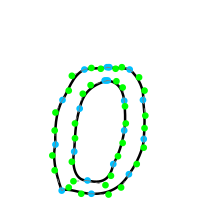

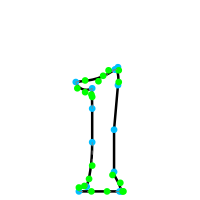

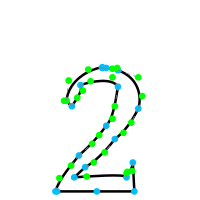

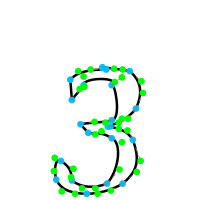

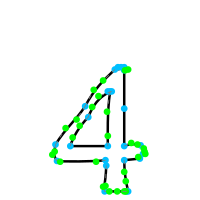

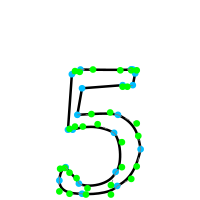

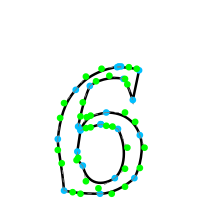

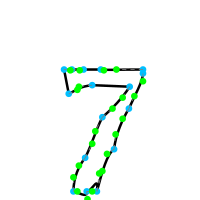

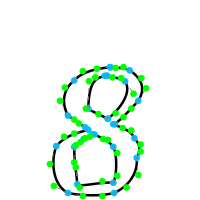

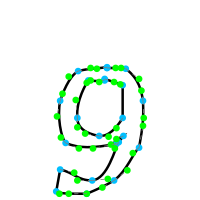

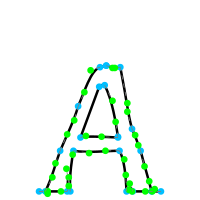

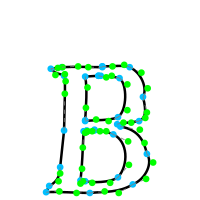

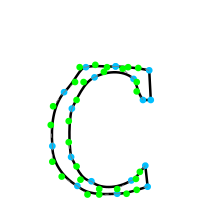

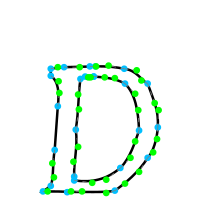

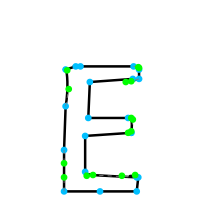

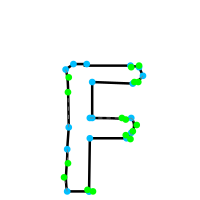

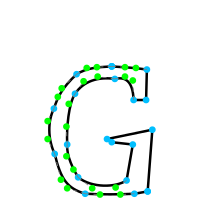

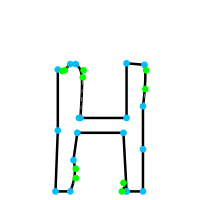

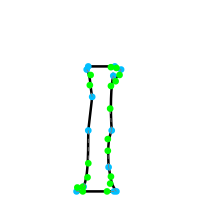

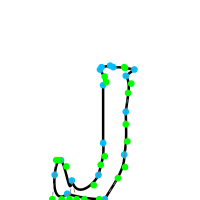

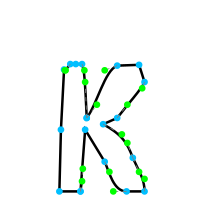

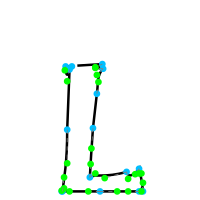

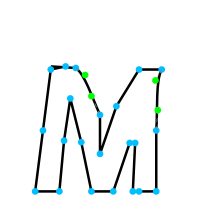

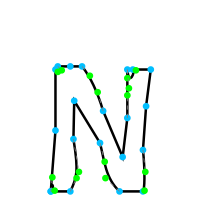

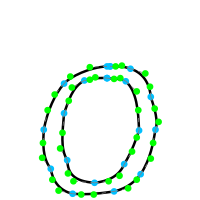

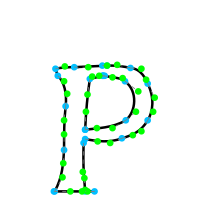

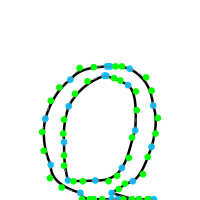

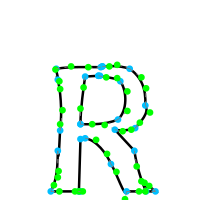

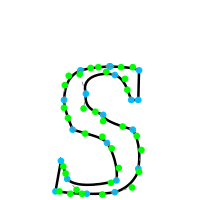

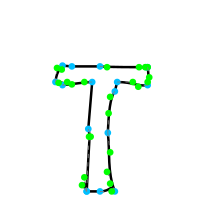

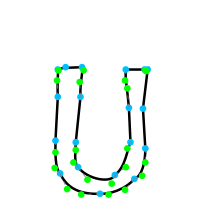

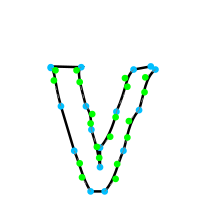

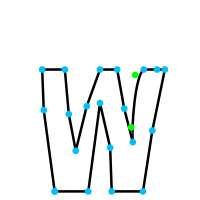

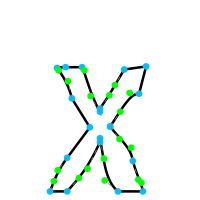

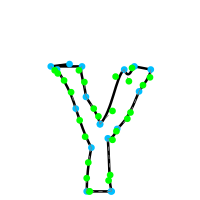

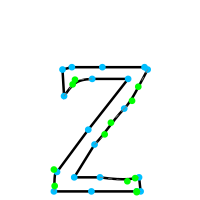

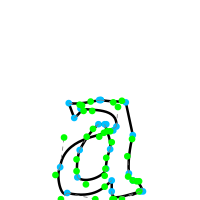

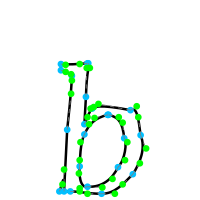

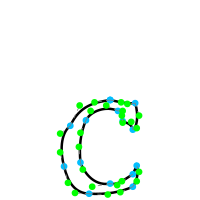

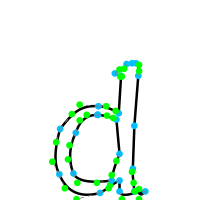

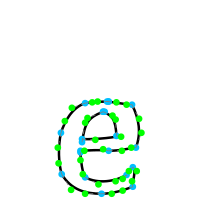

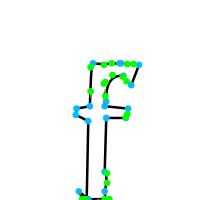

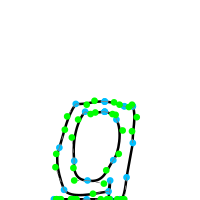

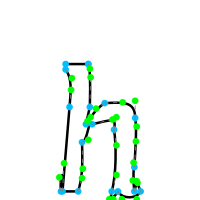

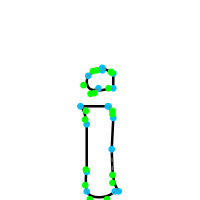

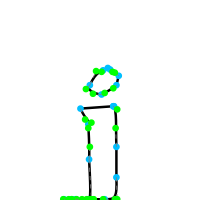

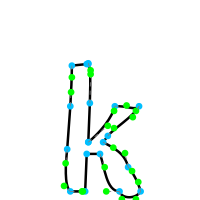

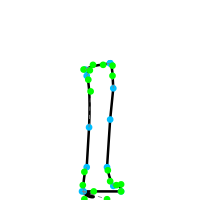

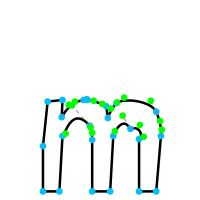

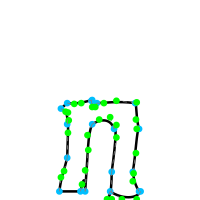

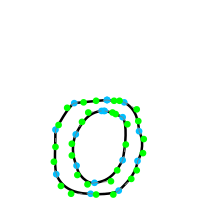

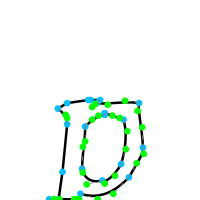

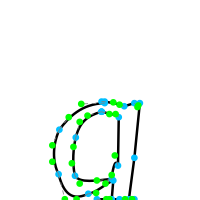

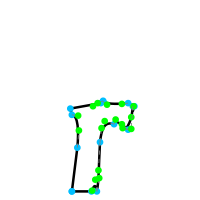

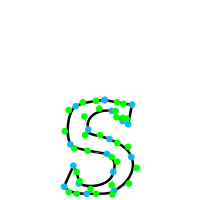

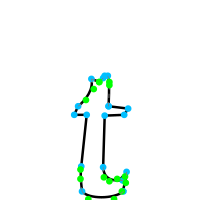

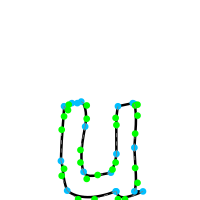

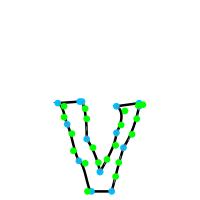

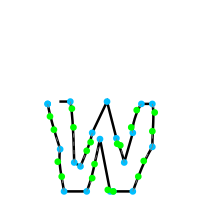

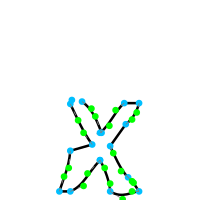

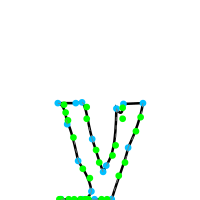

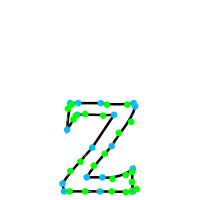

In [39]:
z = get_z()

for c in glyph2label:
    sample_class(c, z=z, with_points=True, with_handles=True, with_moves=False)

Now let's make a convenient grid display of all glyphs!

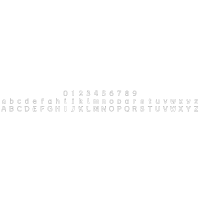

In [28]:
sample_all_glyphs(z)

# Interpolation of font glyphs

Interpolations between randomly generated glyphs

In [36]:
z1, z2 = get_z(), get_z()
interpolate(z1, z2, "9")

Interpolations between real fonts

In [19]:
label = "0"
uni = dataset._label_to_uni(glyph2label.index(label))
id1, id2 = dataset.random_id_by_uni(uni), dataset.random_id_by_uni(uni)
interpolate_icons(id1, id2, label)